# Project1: Restaurants and Ethnical Population Correlation

@Author: Hao

@Date: 1/11/19

## <span style="color:darkblue">Data Exploration</span>
* Restaurants Data from Yelp
  
  * Restaurants in Chicago (by zip code and restaurant type)
  * Restaurants in New York (by zip code and restaurant type)
  
* Population Distribution from Census Bureau:
  
  * Population Distribution in Chicago (by zip code and language)
  * Population Distribution in New York (by zip code and language)

* Restaurants Data from Yelp merged with License Issued Date:
  
  * Merged Dataset of Chicago Restaurants from Yelp anbd Chicago Business License. 
 
## <span style="color:darkblue">Analysis Details</span>
* Analysis I: Correlation of Population Distribution and Restaurant Distribution
    * Conclusion a: Large Minority Population (maximum population percentage more than 4%) tends to go to the restaurants opened by the same population. 
    * Conclusion b: Small Minority Population (maximum population percentage less than 3%) tends to go to the restaurants opened by other population, but with similar food style. 
* Analysis II: Correlation of Restaurants License Issue Pattern by Type
    * The pattern correlations between different types of restaurants are mostly positive.
    * The pattern follows the general financial market cycle, reaches the lowest point around 2008-2009
* Analysis III: Correlation of Review Account by Business Starting Date
    * The overall pattern is: more review count when restaurant opens longer time.
    

## <span style="color:darkblue">Results</span>

### <span style="color:blue"> Analysis I: Minority Population Distribution versus Restaurant Type Distribution</span>

|Colormap|Colormap|
|-----------|-----------|
|<img src="../Chart/Restaurant_Population_Corr_Chicago.png" /> |<img src="../Chart/Restaurant_Population_Corr_New_York.png" /> |


### <span style="color:blue"> Analysis II: Chicago Restaurants License Issue Pattern</span>

##### <span style="color:blue"> Restuarants Open Count by Year (Time Series)</span>
|Line Chart|
|-----------|
|<img src="../Chart/Restaurants_Open_Count_by_Year_Line_Chart.png" />|

##### <span style="color:blue"> Restuarants Open Count Correlation</span>
|Colormap|
|-----------|
|<img src="../Chart/Restaurants_Issue_Number_by_Date_Corr.png" /> |

### <span style="color:blue"> Analysis III: Chicago Restaurants Review Count versus Open Date Pattern</span>

##### <span style="color:blue"> Restuarants Review Count by Year (Time Series)</span>
|Line Chart|
|-----------|
|<img src="../Chart/Restaurants_Review_Count_by_Year_Start_Line_Chart.png" />|

##### <span style="color:blue"> Restuarants Review Count Correlation</span>
|Colormap|
|-----------|
|<img src="../Chart/Restaurants_Review_Number_by_Open_Date_Corr.png" /> |


<br>


# Initialization

In [1]:
## Install Package
!pip install geopy

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [240]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
import difflib

from geopy.distance import vincenty

from config import Google_API

In [3]:
## Import Data
# -----------------------------
# 1.1 Yelp Data Chicago
Yelp_Chicago_df = pd.read_csv("../Data/Yelp_Restaurants_Chicago.csv")
# 1.2 Yelp Data New York
Yelp_New_York_df = pd.read_csv("../Data/Yelp_Restaurants_New_York.csv")
# 2.1 Census by Population Chicago
Population_by_Language_Chicago_df = pd.read_csv("../Data/Population_by_Language_Chicago.csv")
# 2.2 Census by Population New York
Population_by_Language_New_York_df = pd.read_csv("../Data/Population_by_Language_New_York.csv")
# 3.1 Merged Yelp and License Data Chicago
License_Chicago_df = pd.read_csv("../Data/Clean_Chicago_Restaurants_Licenses.csv")

# Analysis I

### Part I: Chicago Restaurants and Population Correlation Analysis

In [4]:
# Get the two data set column names
print(Yelp_Chicago_df.columns)
print(Population_by_Language_Chicago_df.columns)

Index(['zip', 'city', 'state', 'name', 'price', 'rating', 'review_count',
       'type', 'latitude', 'longitude'],
      dtype='object')
Index(['Population', 'English', 'Spanish', 'French', 'Italian', 'Portuguese',
       'German', 'Greek', 'Russian', 'Polish', 'Chinese', 'Japanese', 'Korean',
       'Thai', 'Vietnamese', 'Arabic', 'Zipcode'],
      dtype='object')


In [5]:
## Get Yelp Data by zip Code and Type Pivotal Table
# --------------------------------
# Count restaurants by Zip Code and Type
Yelp_Chicago_by_Zipcode_Type_df = Yelp_Chicago_df.groupby(["zip","type"])["name"].count().reset_index()
Yelp_Chicago_by_Zipcode_Type_df.rename(columns={"name":"count"},inplace=True)
# Convert to pivotal table
Yelp_Chicago_by_Zipcode_Type_pt = Yelp_Chicago_by_Zipcode_Type_df.pivot(index="zip",columns="type",values="count")
# Fill in 0 for NaN
Yelp_Chicago_by_Zipcode_Type_pt = Yelp_Chicago_by_Zipcode_Type_pt.fillna(0)
Yelp_Chicago_Count_by_Zipcode_Type_df = Yelp_Chicago_by_Zipcode_Type_pt.reset_index()
Yelp_Chicago_Count_by_Zipcode_Type_df.head()

type,zip,American (New),Arabian,Argentine,Asian Fusion,Austrian,Brazilian,British,Cajun/Creole,Caribbean,...,Latin American,Malaysian,Mediterranean,Mexican,Pakistani,Polish,Portuguese,Russian,Thai,Vietnamese
0,60601,1.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
1,60602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
2,60603,5.0,0.0,1.0,4.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,60604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60605,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,3.0,1.0


In [6]:
## Get the common list of group names that will be analyzed
common_name_list = list(set(Yelp_Chicago_Count_by_Zipcode_Type_df.columns).intersection(Population_by_Language_Chicago_df.columns))
print(common_name_list)

['Portuguese', 'Japanese', 'German', 'Thai', 'Korean', 'Greek', 'French', 'Russian', 'Vietnamese', 'Chinese', 'Polish', 'Italian']


In [7]:
# Extract Chicago Yelp information needed for analysis
Yelp_Chicago_Count_by_Zipcode_Type_Clean_df = Yelp_Chicago_Count_by_Zipcode_Type_df[["zip"]+common_name_list]
Yelp_Chicago_Count_by_Zipcode_Type_Clean_df.sort_values(by=['zip'],inplace=True)
Yelp_Chicago_Count_by_Zipcode_Type_Clean_df.head()

/Users/haolu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


type,zip,Portuguese,Japanese,German,Thai,Korean,Greek,French,Russian,Vietnamese,Chinese,Polish,Italian
0,60601,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,60602,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
2,60603,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0
3,60604,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60605,1.0,3.0,0.0,3.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0


In [8]:
## Extra population data needed for analysis
# Extract Census Population information needed for analysis
Population_by_Language_Chicago_Clean_df = Population_by_Language_Chicago_df[["Zipcode","Population"]+common_name_list]
Population_by_Language_Chicago_Clean_df.sort_values(by=['Zipcode'],inplace=True)
# Population Percentage of each area
Percentage_by_Language_Chicago_Clean_df = Population_by_Language_Chicago_Clean_df[common_name_list].div(Population_by_Language_Chicago_Clean_df.Population,axis=0)                                                                                             

/Users/haolu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [9]:
## Running Correlation Analysis for each ethnical group (Use Absoluate Population Data)
# Update common_name_list, remove small groups that have less than 2% population in any zip code district. 
comon_name_clean_list = []
for name in common_name_list:
    if Percentage_by_Language_Chicago_Clean_df[name].max()>=0.02:
        comon_name_clean_list.append(name)

# For each Minority group, calculate the correlation of the population distribution versus the restaurants distribution.
corr_matrix = np.zeros((len(comon_name_clean_list),len(comon_name_clean_list)))

for i in range(len(comon_name_clean_list)):
    name_i = comon_name_clean_list[i]
    for j in range(len(comon_name_clean_list)):
        name_j = comon_name_clean_list[j]
        corr_matrix[i,j] = Population_by_Language_Chicago_Clean_df[name_i].corr(Yelp_Chicago_Count_by_Zipcode_Type_Clean_df[name_j],method="pearson")
    
Yelp_common_name_list = [name for name in comon_name_clean_list]
Census_common_name_list = [name+"_%"+str(round(Percentage_by_Language_Chicago_Clean_df[name].max()*100,1)) for name in comon_name_clean_list]

corr_Chicago_df = pd.DataFrame(corr_matrix,index=Census_common_name_list,columns=Yelp_common_name_list)

corr_Chicago_df

,Japanese,Korean,Russian,Vietnamese,Chinese,Polish,Italian
Japanese_%4.4,0.164729,0.187157,-0.015286,0.077402,-0.078414,-0.021822,0.066120
Korean_%13.3,0.368051,0.542699,0.221703,0.142982,0.170628,0.069213,0.246491
Russian_%2.0,0.301696,0.251484,0.169334,0.033119,0.057577,0.097274,0.283955
Vietnamese_%2.4,0.191214,0.408693,0.133490,0.056376,0.160903,0.071257,0.016622
Chinese_%31.9,0.052583,0.225292,-0.057227,0.060608,0.583820,-0.030955,0.195657
Polish_%17.9,0.103457,0.137264,-0.032509,0.015396,0.286837,0.729809,0.202378
Italian_%2.5,0.285310,0.203427,-0.083844,0.001328,0.314524,0.638411,0.382211


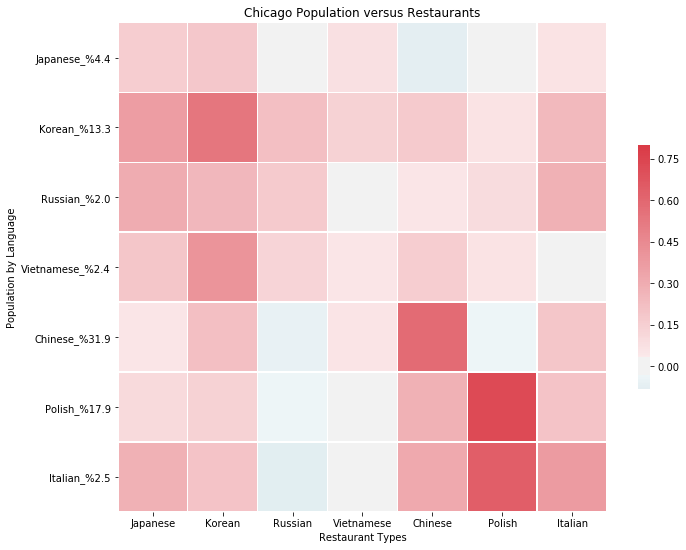

In [10]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_Chicago_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_Chicago_df,  cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Chicago Population versus Restaurants")
plt.xlabel("Restaurant Types")
plt.ylabel("Population by Language")

plt.savefig("../Chart/Restaurant_Population_Corr_Chicago.png")

# Analysis I

### Part II: New York Restaurants and Population Correlation Analysis

In [11]:
## Get Yelp Data by zip Code and Type Pivotal Table
# --------------------------------
# Count restaurants by Zip Code and Type
Yelp_New_York_by_Zipcode_Type_df = Yelp_New_York_df.groupby(["zip","type"])["name"].count().reset_index()
Yelp_New_York_by_Zipcode_Type_df.rename(columns={"name":"count"},inplace=True)
# Convert to pivotal table
Yelp_New_York_by_Zipcode_Type_pt = Yelp_New_York_by_Zipcode_Type_df.pivot(index="zip",columns="type",values="count")
# Fill in 0 for NaN
Yelp_New_York_by_Zipcode_Type_pt = Yelp_New_York_by_Zipcode_Type_pt.fillna(0)
Yelp_New_York_Count_by_Zipcode_Type_df = Yelp_New_York_by_Zipcode_Type_pt.reset_index()
Yelp_New_York_Count_by_Zipcode_Type_df.head()

type,zip,Argentine,Brazilian,British,Bulgarian,Cajun/Creole,Caribbean,Chinese,Cuban,Filipino,...,Japanese,Korean,Malaysian,Mexican,Pakistani,Polish,Portuguese,Russian,Thai,Vietnamese
0,10001,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,11.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0
1,10002,1.0,0.0,1.0,1.0,4.0,0.0,9.0,0.0,3.0,...,4.0,1.0,2.0,3.0,1.0,0.0,1.0,0.0,4.0,7.0
2,10003,0.0,0.0,2.0,0.0,3.0,0.0,7.0,1.0,3.0,...,12.0,5.0,4.0,10.0,0.0,2.0,0.0,2.0,11.0,6.0
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
## Get the common list of group names that will be analyzed
common_name_list = list(set(Yelp_New_York_Count_by_Zipcode_Type_df.columns).intersection(Population_by_Language_New_York_df.columns))
print(common_name_list)

['Portuguese', 'Japanese', 'German', 'Thai', 'Korean', 'Greek', 'French', 'Russian', 'Vietnamese', 'Chinese', 'Polish', 'Italian']


In [13]:
# Extract New York Yelp information needed for analysis
Yelp_New_York_Count_by_Zipcode_Type_Clean_df = Yelp_New_York_Count_by_Zipcode_Type_df[["zip"]+common_name_list]
Yelp_New_York_Count_by_Zipcode_Type_Clean_df.sort_values(by=['zip'],inplace=True)
Yelp_New_York_Count_by_Zipcode_Type_Clean_df.head()

/Users/haolu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


type,zip,Portuguese,Japanese,German,Thai,Korean,Greek,French,Russian,Vietnamese,Chinese,Polish,Italian
0,10001,0.0,1.0,0.0,1.0,11.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0
1,10002,1.0,4.0,3.0,4.0,1.0,2.0,2.0,0.0,7.0,9.0,0.0,2.0
2,10003,0.0,12.0,0.0,11.0,5.0,2.0,5.0,2.0,6.0,7.0,2.0,7.0
3,10004,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,10005,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## Extra population data needed for analysis
# Extract Census Population information needed for analysis
Population_by_Language_New_York_Clean_df = Population_by_Language_New_York_df[["Zipcode","Population"]+common_name_list]
Population_by_Language_New_York_Clean_df.sort_values(by=['Zipcode'],inplace=True)
# Population Percentage of each area
Percentage_by_Language_New_York_Clean_df = Population_by_Language_New_York_Clean_df[common_name_list].div(Population_by_Language_New_York_Clean_df.Population,axis=0)                                                                                             

/Users/haolu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
## Running Correlation Analysis for each ethnical group (Use Absoluate Population Data)
# Update common_name_list, remove small groups that have less than 2% population in any zip code district. 
comon_name_clean_list = []
for name in common_name_list:
    if Percentage_by_Language_New_York_Clean_df[name].max()>=0.02:
        comon_name_clean_list.append(name)

# For each Minority group, calculate the correlation of the population distribution versus the restaurants distribution.
corr_matrix = np.zeros((len(comon_name_clean_list),len(comon_name_clean_list)))

for i in range(len(comon_name_clean_list)):
    name_i = comon_name_clean_list[i]
    for j in range(len(comon_name_clean_list)):
        name_j = comon_name_clean_list[j]
        corr_matrix[i,j] = Population_by_Language_New_York_Clean_df[name_i].corr(Yelp_New_York_Count_by_Zipcode_Type_Clean_df[name_j],method="pearson")
    
Yelp_common_name_list = [name for name in comon_name_clean_list]
Census_common_name_list = [name+"_%"+str(round(Percentage_by_Language_New_York_Clean_df[name].max()*100,1)) for name in comon_name_clean_list]

corr_New_York_df = pd.DataFrame(corr_matrix,index=Census_common_name_list,columns=Yelp_common_name_list)

corr_New_York_df

,Portuguese,Japanese,German,Korean,French,Russian,Chinese,Polish,Italian
Portuguese_%2.4,-0.048359,0.241653,-0.022978,0.155046,0.365883,0.217158,0.084856,0.116112,0.337969
Japanese_%4.1,0.130372,0.477391,0.137488,0.498898,0.418914,0.296127,0.287359,0.167089,0.394887
German_%2.2,0.238579,0.266452,0.140778,0.148747,0.302279,0.049960,0.241883,-0.008861,0.356205
Korean_%7.4,0.116297,0.314421,-0.001406,0.583517,0.295023,0.205395,0.198733,0.299375,0.336097
French_%6.1,0.044027,0.172234,0.084506,0.091471,0.334916,0.021292,0.091039,0.020142,0.242761
Russian_%5.7,0.367713,0.225308,0.268905,0.174746,0.184397,0.089897,0.230791,-0.070774,0.160109
Chinese_%35.1,0.504471,0.242723,0.379368,0.103550,0.128757,-0.024151,0.620108,-0.001466,0.089171
Polish_%2.2,0.362065,0.118469,0.243595,0.204751,0.196145,0.156401,0.166169,-0.067576,0.204143
Italian_%2.0,0.135430,0.395811,0.264438,0.248696,0.570444,0.145483,0.197281,0.078273,0.508676


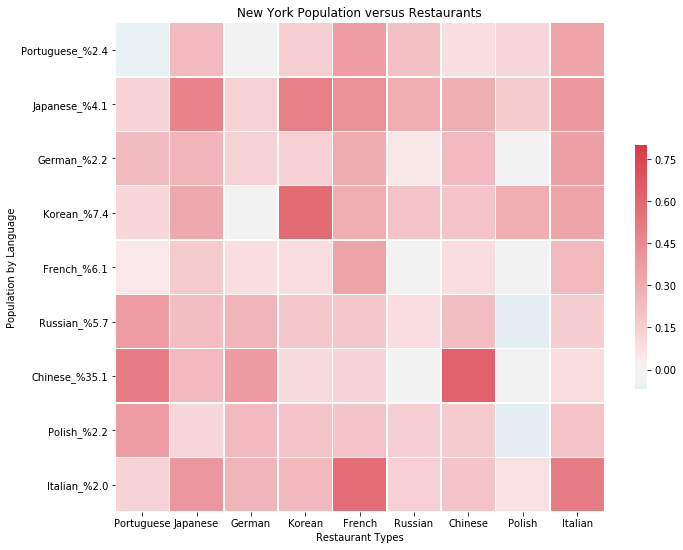

In [16]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_New_York_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_New_York_df,  cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("New York Population versus Restaurants")
plt.xlabel("Restaurant Types")
plt.ylabel("Population by Language")

plt.savefig("../Chart/Restaurant_Population_Corr_New_York.png")

# Data Merge

### Chicago Yelp Data Set and License Data Set

In [17]:
## License Chicago Data Set
License_Chicago_df.head()

,Unnamed: 0,LEGAL NAME,DOING BUSINESS AS NAME,LICENSE CODE,CITY,WARD,ZIP CODE,DATE ISSUED,LATITUDE,LONGITUDE
0,0,"OLD TOWN OIL, LLC","OLD TOWN OIL, LLC",1006,CHICAGO,27.0,60610.0,08/30/2016,41.910408,-87.634540
1,1,MO MO HOUSE CORP.,NEPAL HOUSE - NAPALESE CUISINE,1006,CHICAGO,50.0,60659.0,08/30/2016,41.997535,-87.694822
2,2,"VIENNA SERVICES, INC.",CAFE VIENNA,1006,CHICAGO,43.0,60614.0,08/31/2016,41.928487,-87.642044
3,3,STARBUCKS CORPORATION,STARBUCKS COFFEE #216,1006,CHICAGO,42.0,60611.0,03/18/2015,41.893341,-87.617589
4,4,GENERAL GROWTH MANAGEMENT INC.,GENERAL GROWTH MANAGEMENT INC,1006,CHICAGO,42.0,60606.0,08/31/2016,41.883498,-87.637200


In [18]:
## Yelp Chicago Data Set
Yelp_Chicago_df.head()

,zip,city,state,name,price,rating,review_count,type,latitude,longitude
0,60601,Chicago,IL,Wildberry Pancakes and Cafe,$$,4.5,5862,American (New),41.884668,-87.622880
1,60603,Chicago,IL,The Gage,$$,4.0,2632,American (New),41.881048,-87.624533
2,60603,Chicago,IL,Cindy's,$$,4.0,1387,American (New),41.881689,-87.625006
3,60603,Chicago,IL,The Marq,$$,4.0,509,American (New),41.879619,-87.629925
4,60603,Chicago,IL,Cherry Circle Room,$$$,4.5,330,American (New),41.881664,-87.624969


In [19]:
total_license_count = len(License_Chicago_df)
# Only care about when the business starts. (a.k.a, open date)
License_Chicago_Clean_df = License_Chicago_df.groupby("DOING BUSINESS AS NAME").last().reset_index()
total_license_count_unique = len(License_Chicago_Clean_df)
print (f"Total issued business is {total_license_count}. Total issued business without duplicate business is {total_license_count_unique}")

Total issued business is 140454. Total issued business without duplicate business is 28604


In [20]:
# Initialize the Merging Data Frame
Yelp_License_Merge_Chicago_df = Yelp_Chicago_df
Yelp_License_Merge_Chicago_df["Select_Dist"] = np.nan
Yelp_License_Merge_Chicago_df["Select_Name"] = np.nan
Yelp_License_Merge_Chicago_df["Name_Corr"] = np.nan

In [21]:
## Merging the Two Data Set based on Yelp Chicago
# ------------------------------------------------
merge_count = 0
for index, row in Yelp_License_Merge_Chicago_df.iterrows():
    lat = row["latitude"]
    lng = row["longitude"]
    name = row["name"]
    # Calculate the distance of the Yelp restaurant to all the business with license issued. 
    dist_list = License_Chicago_Clean_df.apply(lambda x: vincenty((x["LATITUDE"], x["LONGITUDE"]), (lat,lng)).meters, axis = 1)
    # Calculate the name correlation score of the Yelp restaurant versus all the business name with license issued
    name_corr_list = License_Chicago_Clean_df.apply(lambda x: difflib.SequenceMatcher(None, x["DOING BUSINESS AS NAME"].lower(), name.lower()).ratio(), axis = 1)
    # Only search for the business within 50 meter radius
    dist_filter_index = dist_list[dist_list <= 50].index
    filtered_name_corr = name_corr_list[dist_filter_index]
    if len(filtered_name_corr) != 0:
        # Find the business with the largest name correlation
        largest_name_corr = max(filtered_name_corr)
        # If name correlation score is less than 50%, drop, return NaN
        if largest_name_corr >= 0.5:
            largest_name_index = filtered_name_corr[filtered_name_corr==largest_name_corr].index[0]
            select_dist = dist_list[largest_name_index]
            select_name = License_Chicago_Clean_df.loc[largest_name_index,"DOING BUSINESS AS NAME"]
            Yelp_License_Merge_Chicago_df.loc[index,"Select_Dist"] = select_dist
            Yelp_License_Merge_Chicago_df.loc[index,"Select_Name"] = select_name
            Yelp_License_Merge_Chicago_df.loc[index,"Name_Corr"] = largest_name_corr
            merge_count = merge_count + 1
            # Output the successfully found results for every 20 iterations. 
            if merge_count % 20 == 0:
                print(f"#Iter {merge_count}: Restaurant name is <{name}>, the selected business name is <{select_name}> with dist is {round(select_dist)} meters and name correlation is %{round(largest_name_corr*100)}")
            

/Users/haolu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':


#Iter 20: Restaurant name is <PR Italian Bistro>, the selected business name is <PR ITALIAN BISTRO> with dist is 11.0 meters and name correlation is %100
#Iter 40: Restaurant name is <Sky Chop Suey>, the selected business name is <#1 CHOP SUEY> with dist is 11.0 meters and name correlation is %80
#Iter 60: Restaurant name is <Lido Banquets>, the selected business name is <LIDO, INC> with dist is 19.0 meters and name correlation is %55
#Iter 80: Restaurant name is <Giant>, the selected business name is <GIANT> with dist is 22.0 meters and name correlation is %100
#Iter 100: Restaurant name is <Pick Me Up Cafe>, the selected business name is <PICK ME UP CAFE> with dist is 6.0 meters and name correlation is %100
#Iter 120: Restaurant name is <MingHin Cuisine>, the selected business name is <MINGHIN on GRANT PARK> with dist is 33.0 meters and name correlation is %50
#Iter 140: Restaurant name is <Chant>, the selected business name is <CHANT> with dist is 3.0 meters and name correlation is 

#Iter 1120: Restaurant name is <Rainbow Cuisine>, the selected business name is <RAINBOW> with dist is 24.0 meters and name correlation is %64
#Iter 1140: Restaurant name is <Thai on Clark>, the selected business name is <THAI ON CLARK> with dist is 16.0 meters and name correlation is %100
#Iter 1160: Restaurant name is <Andy's Thai Kitchen>, the selected business name is <Andy's Thai Kitchen> with dist is 5.0 meters and name correlation is %100
#Iter 1180: Restaurant name is <Simply It>, the selected business name is <SIMPLY IT> with dist is 10.0 meters and name correlation is %100
#Iter 1200: Restaurant name is <Pasteur>, the selected business name is <PASTEUR> with dist is 34.0 meters and name correlation is %100
#Iter 1220: Restaurant name is <Amazing Kababs & Grill>, the selected business name is <AMAZING KABABS & GRILL> with dist is 17.0 meters and name correlation is %100
#Iter 1240: Restaurant name is <Serena Restaurant>, the selected business name is <SERENA RESTAURANT> with d

In [181]:
## Find the first license issued date from license data set
License_Chicago_First_Issue_df = License_Chicago_df.groupby("DOING BUSINESS AS NAME").last().reset_index()
License_Chicago_Last_Issue_df = License_Chicago_df.groupby("DOING BUSINESS AS NAME").first().reset_index()

print(License_Chicago_Last_Issue_df.head())
print(License_Chicago_First_Issue_df.head())

              DOING BUSINESS AS NAME  Unnamed: 0                 LEGAL NAME  \
0  "C"  A CATERING AND EVENT COMPANY       11496  BELLA DONNA CATERING, LLC   
1                          "DULCE V"       15157         DULCE VENTURES LLC   
2                   "GENGHIS" EATERY        1831             GANSUKH SHATAR   
3                        "MI-TIERRA"      102566          ARBOL GRANDE, INC   
4          "SABOR MEXICO" RESTAURANT       19465                DIVICA INC.   

   LICENSE CODE     CITY  WARD  ZIP CODE DATE ISSUED   LATITUDE  LONGITUDE  
0          1006  CHICAGO  38.0   60634.0  11/07/2017  41.958699 -87.767332  
1          1006  CHICAGO  23.0   60638.0  03/14/2018  41.794367 -87.771896  
2          1006  CHICAGO  47.0   60613.0  09/25/2012  41.961477 -87.669571  
3          1006  CHICAGO  46.0   60640.0  08/23/2002  41.968491 -87.659816  
4          1006  CHICAGO  22.0   60623.0  08/13/2018  41.844295 -87.713049  
              DOING BUSINESS AS NAME  Unnamed: 0               

In [183]:
## Use merged data set of Yelp and License to extract restaurants' last license issue date. 
# Initialize
Yelp_License_Merge_Chicago_df["First_Date_Issued"] = np.nan
Yelp_License_Merge_Chicago_df["Last_Date_Issued"] = np.nan
# Loop through and use Doing Business as Name as search criterion
for index, row in Yelp_License_Merge_Chicago_df.iterrows():
    name = row["Select_Name"]
    First_Date_Issued = License_Chicago_First_Issue_df[License_Chicago_First_Issue_df["DOING BUSINESS AS NAME"]==name]["DATE ISSUED"].tolist()[0]
    Last_Date_Issued = License_Chicago_Last_Issue_df[License_Chicago_Last_Issue_df["DOING BUSINESS AS NAME"]==name]["DATE ISSUED"].tolist()[0]
    Yelp_License_Merge_Chicago_df.loc[index,"First_Date_Issued"] = First_Date_Issued
    Yelp_License_Merge_Chicago_df.loc[index,"Last_Date_Issued"] = Last_Date_Issued

Yelp_License_Merge_Chicago_df.head()

,zip,city,state,name,price,rating,review_count,type,latitude,longitude,Select_Dist,Select_Name,Name_Corr,Year_Issued,First_Date_Issued,Last_Date_Issued
0,60601,Chicago,IL,Wildberry Pancakes and Cafe,$$,4.5,5862,American (New),41.884668,-87.622880,33.761703,WILDBERRY PANCAKES & CAFE,0.923077,2017,08/31/2015,09/13/2017
1,60603,Chicago,IL,The Marq,$$,4.0,509,American (New),41.879619,-87.629925,12.416881,THE MARQ,1.000000,2016,10/24/2014,10/11/2016
2,60603,Chicago,IL,Cherry Circle Room,$$$,4.5,330,American (New),41.881664,-87.624969,41.587182,THE CHERRY CIRCLE ROOM,0.900000,2017,05/15/2015,06/30/2017
3,60603,Chicago,IL,The Berghoff Restaurant,$$,3.5,962,American (New),41.879333,-87.628668,21.276031,BERGHOFF'S RESTAURANT,0.863636,2005,05/10/2004,05/12/2005
4,60607,Chicago,IL,Girl & the Goat,$$$,4.5,7886,American (New),41.884105,-87.647944,22.328921,GIRL & THE GOAT,1.000000,2018,06/21/2012,06/15/2018


In [184]:
# Clean the nan data
Yelp_License_Merge_Chicago_df = Yelp_License_Merge_Chicago_df.dropna(how='any')
Yelp_License_Merge_Chicago_df.to_csv("../Data/Yelp_License_Merge.csv",index=False)

# Analysis II

### Restaurant Type Analysis by Issue Date

In [172]:
## Clean the data, drop the rows that have NAN value (a.k.a, the restaurant that cannot find in the license data set)
Yelp_License_Merge_Chicago_df = pd.read_csv("../Data/Yelp_License_Merge.csv") # Extract directly since the data already saved
Yelp_License_Merge_Chicago_df.dropna(how='any',inplace=True)
len(Yelp_License_Merge_Chicago_df)

1246

In [186]:
## Get the Issue Year of each Restaurant
Yelp_License_Merge_Chicago_df["Year_Issued"] = pd.DatetimeIndex(Yelp_License_Merge_Chicago_df["First_Date_Issued"]).year
Yelp_License_Merge_Chicago_df.head()

,zip,city,state,name,price,rating,review_count,type,latitude,longitude,Select_Dist,Select_Name,Name_Corr,Year_Issued,First_Date_Issued,Last_Date_Issued
0,60601,Chicago,IL,Wildberry Pancakes and Cafe,$$,4.5,5862,American (New),41.884668,-87.622880,33.761703,WILDBERRY PANCAKES & CAFE,0.923077,2015,08/31/2015,09/13/2017
1,60603,Chicago,IL,The Marq,$$,4.0,509,American (New),41.879619,-87.629925,12.416881,THE MARQ,1.000000,2014,10/24/2014,10/11/2016
2,60603,Chicago,IL,Cherry Circle Room,$$$,4.5,330,American (New),41.881664,-87.624969,41.587182,THE CHERRY CIRCLE ROOM,0.900000,2015,05/15/2015,06/30/2017
3,60603,Chicago,IL,The Berghoff Restaurant,$$,3.5,962,American (New),41.879333,-87.628668,21.276031,BERGHOFF'S RESTAURANT,0.863636,2004,05/10/2004,05/12/2005
4,60607,Chicago,IL,Girl & the Goat,$$$,4.5,7886,American (New),41.884105,-87.647944,22.328921,GIRL & THE GOAT,1.000000,2012,06/21/2012,06/15/2018


In [187]:
# Group Restaurants by Year_Issued and Type
Restaurants_Chicago_Count_Time_Series_df = Yelp_License_Merge_Chicago_df.groupby(["Year_Issued","type"])["name"].count().reset_index()
Restaurants_Chicago_Count_Time_Series_df.rename(columns={"name":"count"},inplace=True)

# Create Pivot Table
Restaurants_Chicago_Count_Time_Series_pt = Restaurants_Chicago_Count_Time_Series_df.pivot(index="Year_Issued",columns="type",values="count")
Restaurants_Chicago_Count_Time_Series_pt.fillna(0,inplace=True)

Restaurants_Chicago_Count_Time_Series_pt.head()

type,American (New),Arabian,Argentine,Asian Fusion,Austrian,Brazilian,British,Cajun/Creole,Caribbean,Chinese,...,Latin American,Malaysian,Mediterranean,Mexican,Pakistani,Polish,Portuguese,Russian,Thai,Vietnamese
Year_Issued,,,,,,,,,,,,,,,,,,,,,
2002,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,1.0,0.0,1.0,6.0,1.0,1.0,0.0,0.0,4.0,0.0
2003,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,2.0
2004,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,...,1.0,0.0,2.0,9.0,0.0,2.0,0.0,0.0,3.0,0.0
2005,3.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,5.0,...,2.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,4.0,2.0
2006,5.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,8.0,...,2.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,2.0,3.0


In [298]:
## Analysis on a small set of restaurants
name_List = ["Japanese","Polish","Korean","Italian","Vietnamese","Chinese","Russian"]
Filter_Restaurants_Chicago_Count_Time_Series_df = Restaurants_Chicago_Count_Time_Series_df.loc[Restaurants_Chicago_Count_Time_Series_df["type"].isin(name_List)]

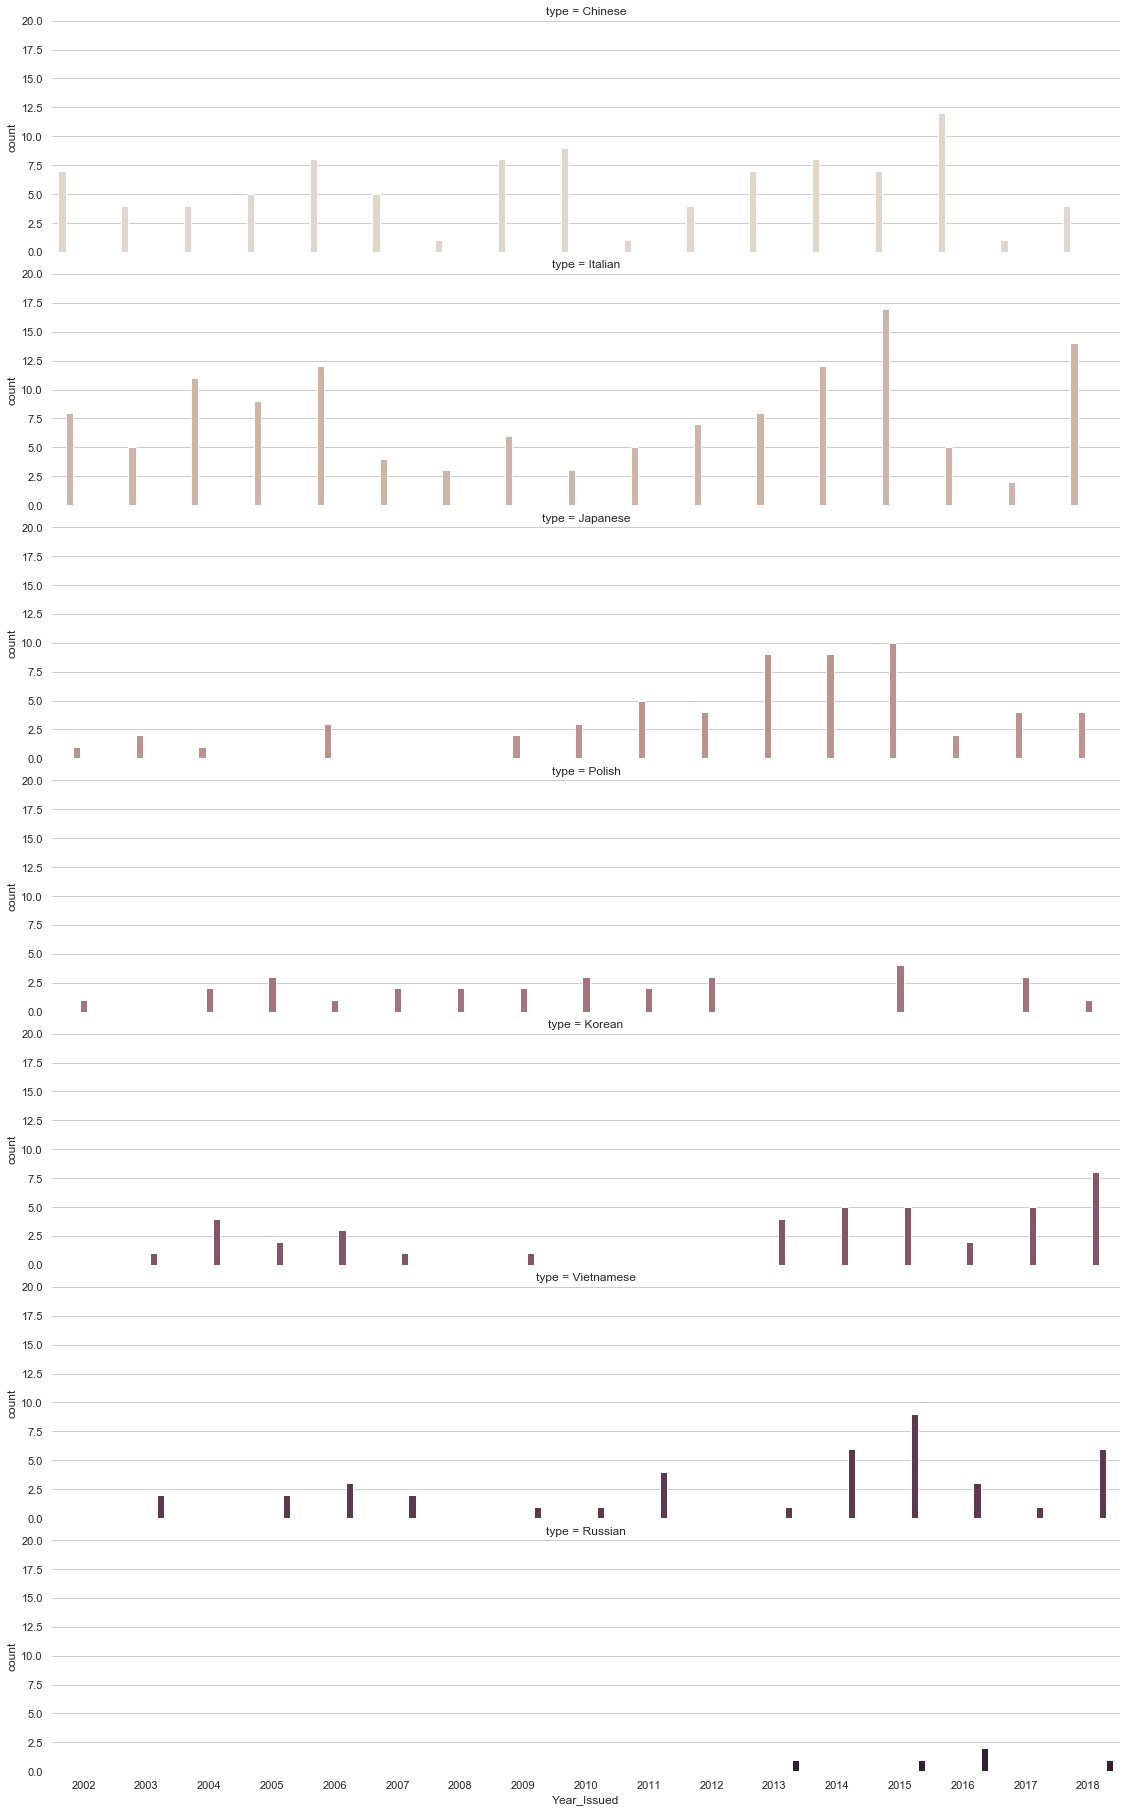

In [299]:
## Restaurants Open by Year Bar Chart
sns.set_style("whitegrid")
sns_plot = sns.catplot(x="Year_Issued", y="count", hue="type",kind="bar", row="type",palette="ch:.25",data = Filter_Restaurants_Chicago_Count_Time_Series_df)
sns.despine(left=True, bottom=True)
plt.ylim(0, 20)

sns_plot.fig.set_figheight(25)
sns_plot.fig.set_figwidth(18)

sns_plot.savefig('../Chart/Restaurants_Open_Count_by_Year_Bar_Chart.png')

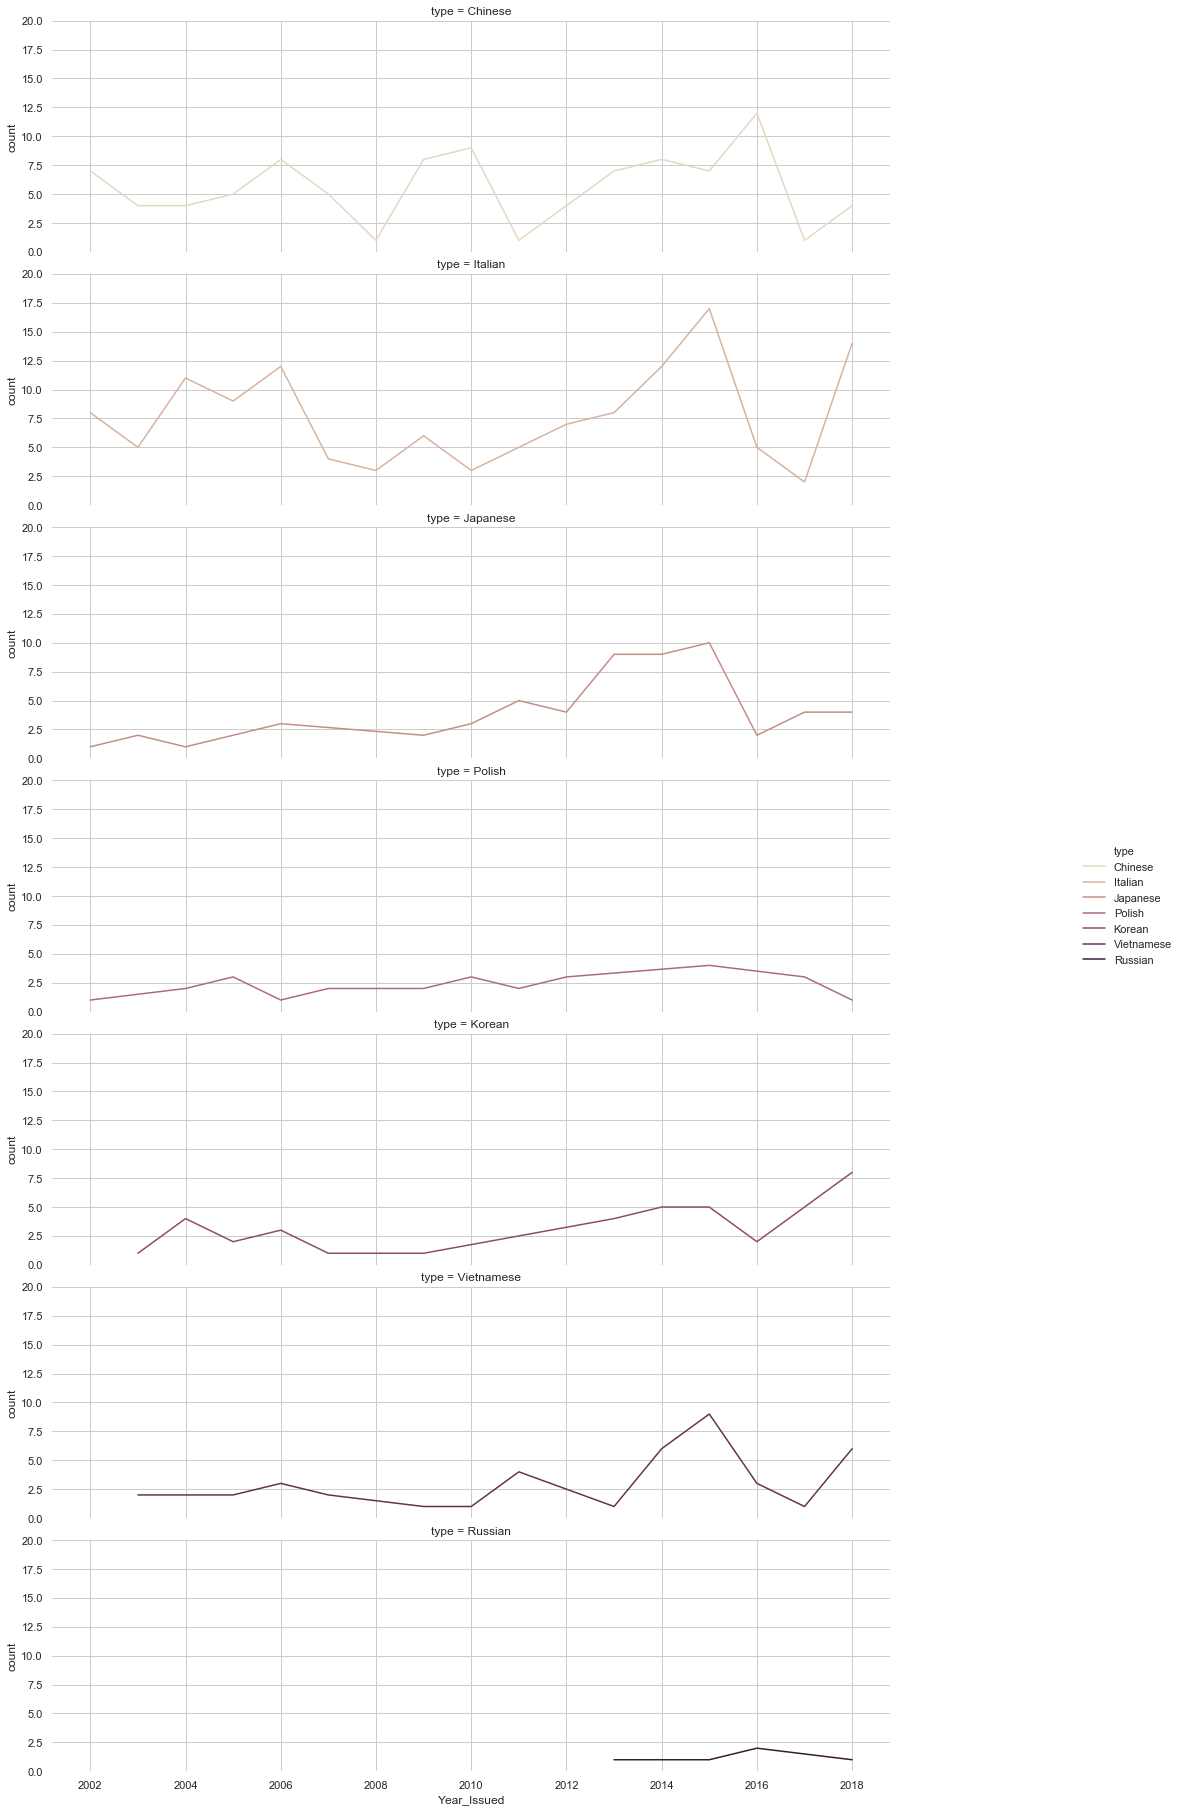

In [300]:
## Restaurants Open by Year Line Chart
sns.set_style("whitegrid")
sns_plot = sns.relplot(x="Year_Issued", y="count",hue="type", kind="line", row="type",palette="ch:.25",
            data=Filter_Restaurants_Chicago_Count_Time_Series_df);
sns.despine(left=True, bottom=True)
plt.ylim(0, 20)

sns_plot.fig.set_figheight(25)
sns_plot.fig.set_figwidth(18)

sns_plot.savefig('../Chart/Restaurants_Open_Count_by_Year_Line_Chart.png')

In [301]:
# Correlation of the license issue pattern
time_series_corr = Restaurants_Chicago_Count_Time_Series_pt[name_List].corr(method="pearson")
time_series_corr

type,Japanese,Polish,Korean,Italian,Vietnamese,Chinese,Russian
type,,,,,,,
Japanese,1.000000,-0.056670,0.504757,0.498227,0.636358,0.168488,0.322094
Polish,-0.056670,1.000000,-0.122513,-0.005455,0.020537,-0.324018,-0.297059
Korean,0.504757,-0.122513,1.000000,0.647194,0.583226,0.016007,0.396172
Italian,0.498227,-0.005455,0.647194,1.000000,0.683374,0.233947,0.260790
Vietnamese,0.636358,0.020537,0.583226,0.683374,1.000000,0.183030,0.414320
Chinese,0.168488,-0.324018,0.016007,0.233947,0.183030,1.000000,0.487971
Russian,0.322094,-0.297059,0.396172,0.260790,0.414320,0.487971,1.000000


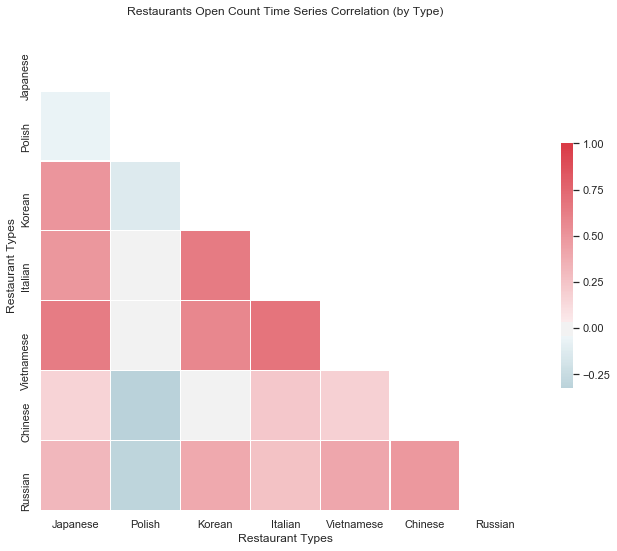

In [302]:
mask = np.zeros_like(time_series_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(time_series_corr, mask=mask, cmap=cmap, vmax= 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Restaurants Open Count Time Series Correlation (by Type)")
plt.xlabel("Restaurant Types")
plt.ylabel("Restaurant Types")

plt.savefig("../Chart/Restaurants_Issue_Number_by_Date_Corr.png")

# Analysis III

### Restaurant Type Review by License Duration

In [303]:
## Review Count by Restaurant Open Date
Yelp_License_Merge_Chicago_df["RC_Start_Year"] = np.maximum(Yelp_License_Merge_Chicago_df["Year_Issued"],2012)

Restaurants_Chicago_Review_Count_by_Issue_Year_df = Yelp_License_Merge_Chicago_df.groupby(["RC_Start_Year","type"])["review_count"].mean().reset_index()
Restaurants_Chicago_Review_Count_by_Issue_Year_df.head()

,RC_Start_Year,type,review_count
0,2012,American (New),917.326087
1,2012,Argentine,1409.500000
2,2012,Asian Fusion,552.736842
3,2012,Brazilian,605.857143
4,2012,British,457.000000


In [304]:
Filter_Restaurants_Chicago_Review_Count_by_Issue_Year_df = Restaurants_Chicago_Review_Count_by_Issue_Year_df.loc[Restaurants_Chicago_Review_Count_by_Issue_Year_df["type"].isin(name_List)]

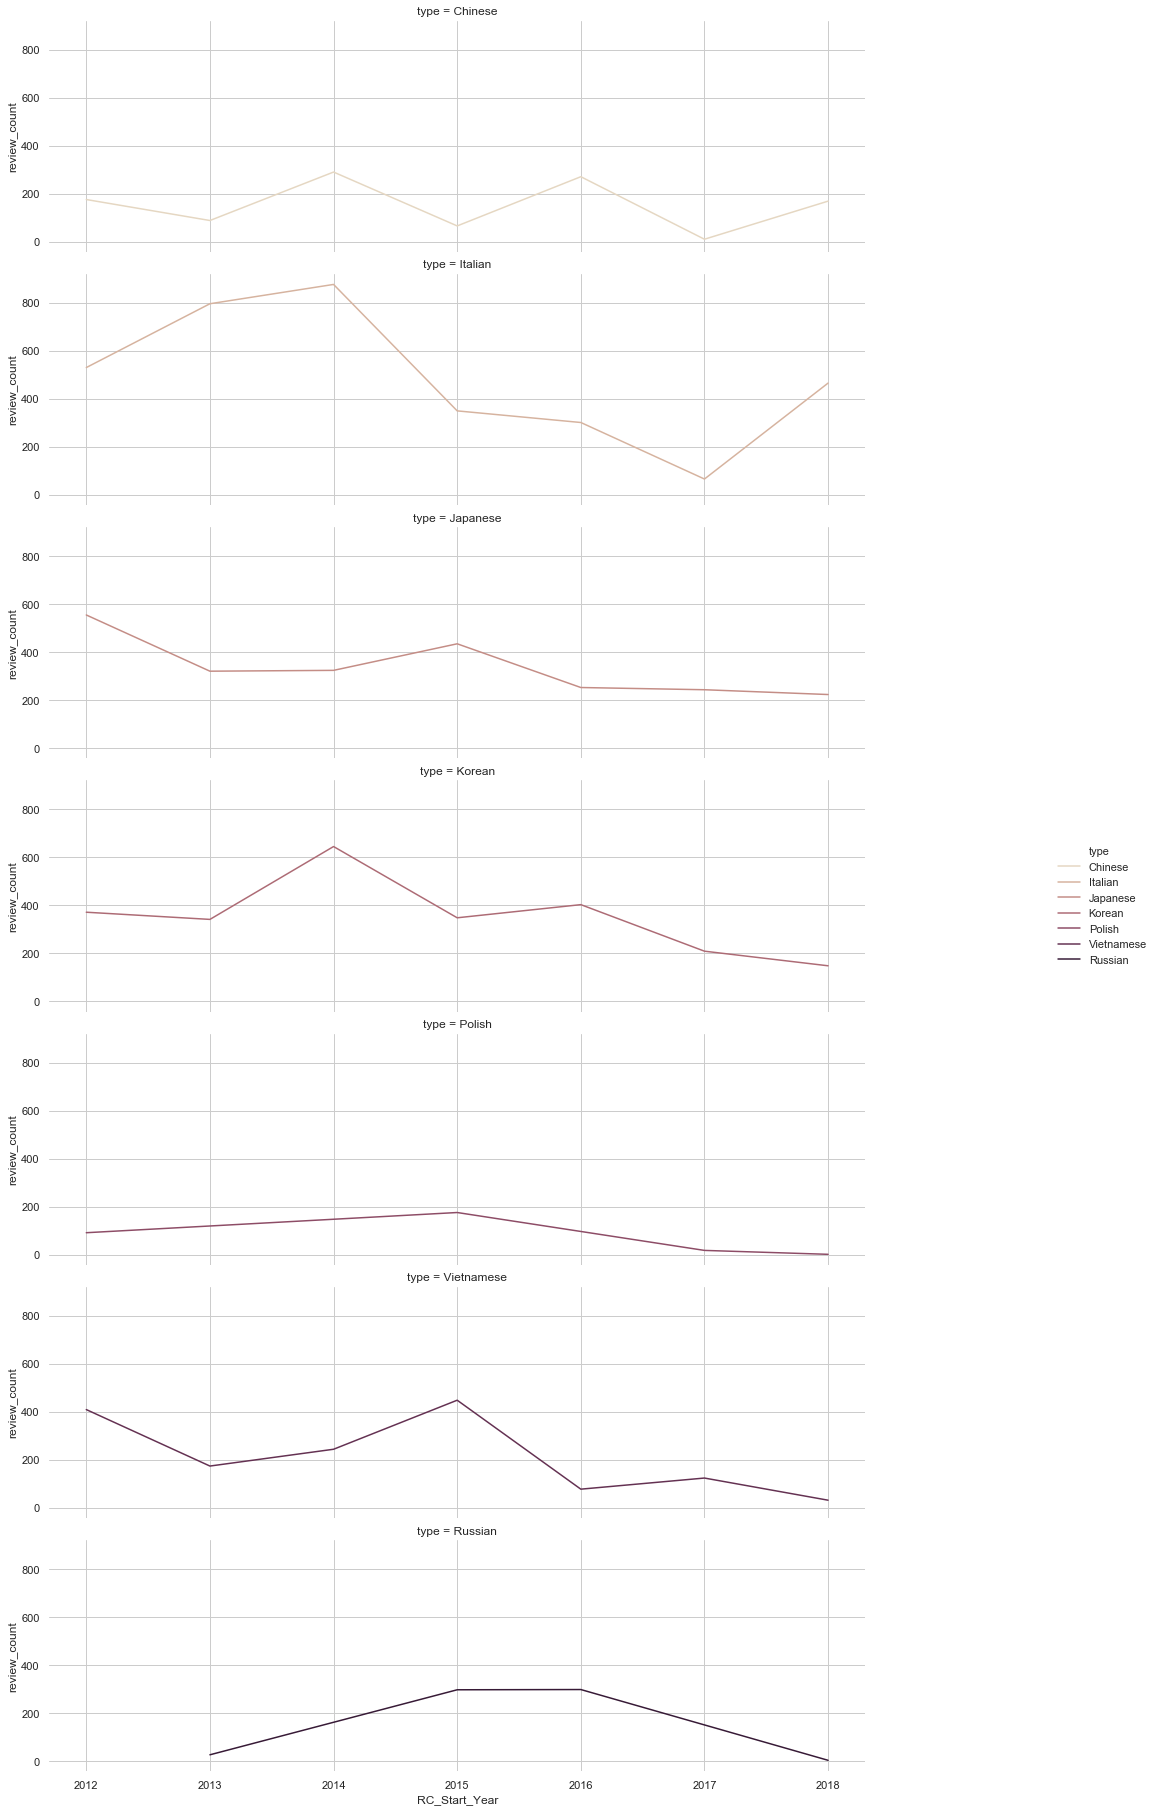

In [305]:
## Restaurants Open by Year Line Chart
sns.set_style("whitegrid")
sns_plot = sns.relplot(x="RC_Start_Year", y="review_count",hue="type", kind="line", row="type",palette="ch:.25",
            data=Filter_Restaurants_Chicago_Review_Count_by_Issue_Year_df);
sns.despine(left=True, bottom=True)

sns_plot.fig.set_figheight(25)
sns_plot.fig.set_figwidth(18)

sns_plot.savefig('../Chart/Restaurants_Review_Count_by_Year_Start_Line_Chart.png')

In [306]:
# Correlation of the license issue pattern
Filter_Restaurants_Chicago_Review_Count_by_Issue_Year_pt = Filter_Restaurants_Chicago_Review_Count_by_Issue_Year_df.pivot(index="RC_Start_Year",columns="type",values="review_count")

review_time_series_corr = Filter_Restaurants_Chicago_Review_Count_by_Issue_Year_pt[name_List].corr(method="pearson")
review_time_series_corr

type,Japanese,Polish,Korean,Italian,Vietnamese,Chinese,Russian
type,,,,,,,
Japanese,1.000000,0.724385,0.284690,0.213411,0.918683,-0.035822,0.462216
Polish,0.724385,1.000000,0.851988,0.218858,0.929017,-0.107422,1.000000
Korean,0.284690,0.851988,1.000000,0.621701,0.360103,0.651019,0.717158
Italian,0.213411,0.218858,0.621701,1.000000,0.156415,0.474690,-0.755078
Vietnamese,0.918683,0.929017,0.360103,0.156415,1.000000,-0.152927,0.510565
Chinese,-0.035822,-0.107422,0.651019,0.474690,-0.152927,1.000000,0.227851
Russian,0.462216,1.000000,0.717158,-0.755078,0.510565,0.227851,1.000000


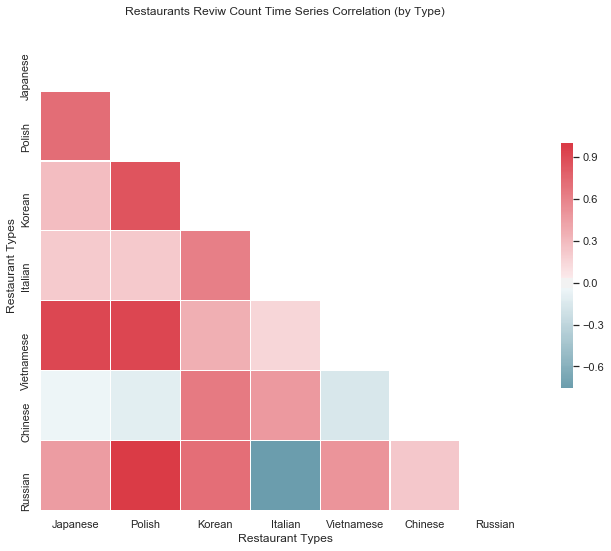

In [308]:
mask = np.zeros_like(review_time_series_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(review_time_series_corr, mask=mask, cmap=cmap, vmax= 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Restaurants Reviw Count Time Series Correlation (by Type)")
plt.xlabel("Restaurant Types")
plt.ylabel("Restaurant Types")

plt.savefig("../Chart/Restaurants_Review_Number_by_Open_Date_Corr.png")